<a href="https://colab.research.google.com/github/yucaret/Data_Analysis/blob/main/NSF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install scikit-learn

In [2]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/"My Drive"/Iniciativas/20231203_globant

Mounted at /content/drive
/content/drive/My Drive/Iniciativas/20231203_globant


In [3]:
import numpy as np
import pandas as pd

# Data upload

In [5]:
import xml.etree.ElementTree as ET
import os
from zipfile import ZipFile

# Directorio donde se encuentra el archivo zip
directorio_zip = './1_fuente/2020.zip'

# Directorio donde se extraerán los archivos XML
directorio_destino = '1_fuente/xml'

# Descomprimir el archivo zip
with ZipFile(directorio_zip, 'r') as zip_ref:
    zip_ref.extractall(directorio_destino)

In [6]:
# Lista para almacenar los datos de cada archivo
datos_abstractos = []

# Recorre cada archivo en el directorio destino
for archivo_xml in os.listdir(directorio_destino):
    if archivo_xml.endswith(".xml"):
        ruta_completa = os.path.join(directorio_destino, archivo_xml)

        # Parsea el archivo XML
        tree = ET.parse(ruta_completa)
        root = tree.getroot()

        # Extrae información relevante
        titulo = root.find('.//AwardTitle').text
        tipo_premio = root.find('.//AwardInstrument/Value').text
        #investigador_principal = root.find('.//Investigator/PI_FULL_NAME').text
        #institucion = root.find('.//Institution/Name').text
        resumen = root.find('.//AbstractNarration').text
        division = root.find('.//Division/LongName').text
        directorate = root.find('.//Directorate/LongName').text

        # Almacena los datos en un diccionario
        datos_abstracto = {
            'Titulo': titulo,
            'TipoPremio': tipo_premio,
            #'InvestigadorPrincipal': investigador_principal,
            #'Institucion': institucion,
            'Resumen': resumen,
            'Division': division,
            'Directorate': directorate
        }

        datos_abstractos.append(datos_abstracto)

# Muestra los datos de ejemplo
#for abstracto in datos_abstractos:
#    print(abstracto)

In [7]:
datos_abstractos[0]

{'Titulo': 'EAGER: Collaborative Research: Detection and Analysis of Airborne Coronavirus with Bioinspired Membranes',
 'TipoPremio': 'Standard Grant',
 'Resumen': "The spread of biological pathogens via aerosolized droplets continues to be of primary concern during the current COVID-19 pandemic. Thus, the ability to capture and analyze aerosolized pathogens is critical to understand and mitigate the potential for reoccurring outbreaks of COVID-19 or other novel pathogens. To address this need, an interdisciplinary research team from the University of Maine and the University of Massachusetts Amherst will engineer a bioinspired technology that facilitates the efficient collection of viruses from bioaerosols. The inspiration for the technology is the carnivorous Nepenthes pitcher plant, which has a slippery rim and inner walls causing insects to fall and become trapped within its digestive fluid. By engineering a composite material comprised of a liquid layer on the surface of a membran

# Text Preprocessing

In [8]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re

# Descargar recursos necesarios de nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Función de preprocesamiento de texto
def preprocesar_texto(texto):
    texto = texto.lower()

    texto = re.sub(r'[^a-z\s]', '', texto) # Eliminar caracteres especiales y números

    tokens = word_tokenize(texto) # Tokenización

    # Eliminación de stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Lematización
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Unir tokens para formar el texto preprocesado
    texto_preprocesado = ' '.join(tokens)

    return texto_preprocesado

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [9]:
# Aplicar preprocesamiento a cada resumen en tus datos
for abstracto in datos_abstractos:
    abstracto['TituloPreprocesado'] = preprocesar_texto(str(abstracto['Titulo']))

for abstracto in datos_abstractos:
    abstracto['DivisionPreprocesado'] = preprocesar_texto(str(abstracto['Division']))

for abstracto in datos_abstractos:
    abstracto['DirectoratePreprocesado'] = preprocesar_texto(str(abstracto['Directorate']))

for abstracto in datos_abstractos:
    abstracto['ResumenPreprocesado'] = preprocesar_texto(str(abstracto['Resumen']))

# Text Representation

In [10]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [16]:
# Campos a considerar para la representación de texto
campos_texto = ['TituloPreprocesado', 'ResumenPreprocesado', 'DivisionPreprocesado', 'DirectoratePreprocesado']

# Concatenar todos los campos de texto preprocesado en uno solo
for abstracto in datos_abstractos:
    abstracto['TextoCompleto'] = ' '.join([abstracto[campo] for campo in campos_texto])

# Crear el vectorizador TF-IDF
#vectorizer = TfidfVectorizer()

# Configuración de TfidfVectorizer con limitación de características, ajuste de IDF y n-gramas
vectorizer = TfidfVectorizer(max_features=1000, smooth_idf=False, sublinear_tf=True, ngram_range=(2, 3))

# Obtener la matriz TF-IDF
matriz_tfidf = vectorizer.fit_transform([abstracto['TextoCompleto'] for abstracto in datos_abstractos])

# La matriz_tfidf contiene la representación numérica de los textos
#print(matriz_tfidf.toarray())

In [ ]:
type(matriz_tfidf)

scipy.sparse._csr.csr_matrix

In [ ]:
matriz_tfidf.shape

(13300, 76821)

# Visualization

In [17]:
# Seleccionar 2000 registros de manera aleatoria
indices_aleatorios = np.random.choice(matriz_tfidf.shape[0], size=4000, replace=False)
subset_datos = matriz_tfidf[indices_aleatorios]

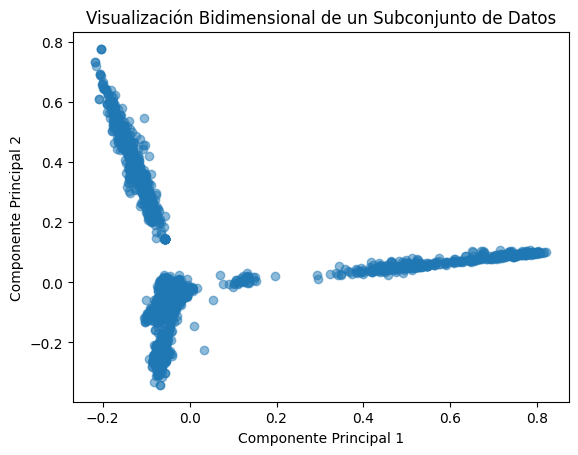

In [18]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Reducción de dimensionalidad con PCA
pca = PCA(n_components=2)

# Transformar el subconjunto con PCA
componentes_principales = pca.fit_transform(subset_datos.toarray())

# Visualización en un gráfico bidimensional
plt.scatter(componentes_principales[:, 0], componentes_principales[:, 1], alpha=0.5)
plt.title('Visualización Bidimensional de un Subconjunto de Datos')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.show()

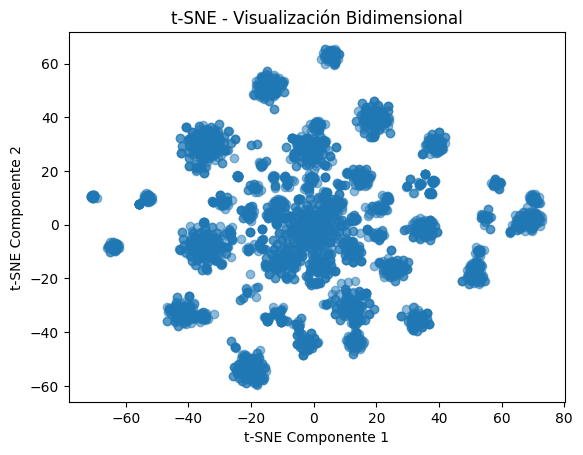

In [19]:
from sklearn.manifold import TSNE

# Reducción de dimensionalidad con t-SNE
tsne = TSNE(n_components=2, random_state=42)
componentes_tsne = tsne.fit_transform(subset_datos.toarray())

# Visualización en gráfico bidimensional (t-SNE)
plt.scatter(componentes_tsne[:, 0], componentes_tsne[:, 1], alpha=0.5)
plt.title('t-SNE - Visualización Bidimensional')
plt.xlabel('t-SNE Componente 1')
plt.ylabel('t-SNE Componente 2')
plt.show()

In [20]:
def plot_analisis_codo_silueta(data_compoenente, clusters_maximos):

  if(clusters_maximos < 1):
    clusters_maximos = 2

  # Lista para almacenar los valores de inercia (codo) y silueta para cada número de clusters
  inertia_values = []
  silhouette_scores = []

  # Rango de números de clusters que deseas probar
  cluster_range = list(range(2, clusters_maximos + 1))

  for n_clusters in cluster_range:
      # Ajusta el modelo K-means
      kmeans = KMeans(n_clusters=n_clusters, n_init=100)
      kmeans.fit(data_compoenente)

      ## Calcula la inercia (codo) y el score de silueta
      inertia_values.append(kmeans.inertia_)
      silhouette_scores.append(silhouette_score(data_compoenente, kmeans.labels_))

  # Gráfico del método del codo
  plt.figure(figsize=(12, 5))
  plt.subplot(1, 2, 1)
  plt.plot(cluster_range, inertia_values, marker='o', linestyle='-', color='b')
  plt.xlabel('Número de Clusters')
  plt.ylabel('Inercia')
  plt.title('Método del Codo')

  # Gráfico del método de la silueta
  plt.subplot(1, 2, 2)
  plt.plot(cluster_range, silhouette_scores, marker='o', linestyle='-', color='g')
  plt.xlabel('Número de Clusters')
  plt.ylabel('Puntuación de Silueta')
  plt.title('Método de la Silueta')

  plt.tight_layout()
  plt.show()

In [ ]:
plot_analisis_codo_silueta(componentes_principales, 10)

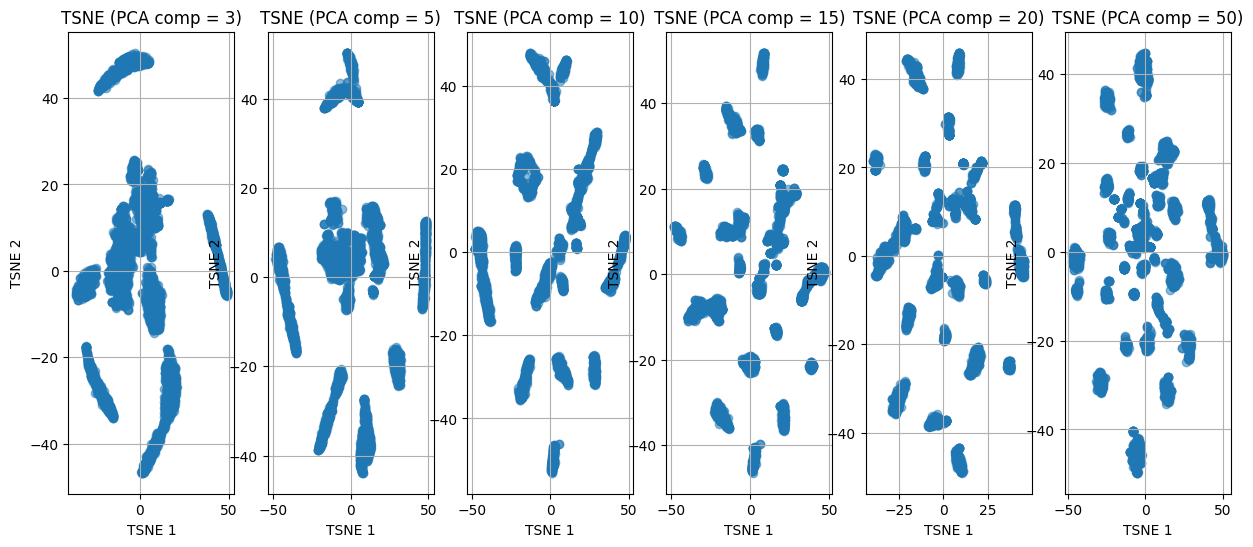

In [21]:
list_n_components = [3, 5, 10, 15, 20, 50]

plt.figure(figsize=(15, 6))

#for n_c in list_n_components:
for i, n_c in enumerate(list_n_components):

    pca = PCA(n_components = n_c)
    data_componente = pca.fit_transform(subset_datos.toarray())

    # Initialize and fit a t-SNE model with perplexity=40 on the PCA-transformed data
    tsne = TSNE(n_components = 2, perplexity = 100 )
    tsne_results = tsne.fit_transform(data_componente)

    tsne_df = pd.DataFrame(data= tsne_results, columns=['tsne_1', 'tsne_2'])

    # Crear un diagrama de dispersión de las proyecciones en los dos componentes principales
    #plt.figure(figsize=(8, 6))
    plt.subplot(1, len(list_n_components), i + 1)
    plt.scatter(tsne_df['tsne_1'], tsne_df['tsne_2'], alpha=0.5)
    plt.xlabel('TSNE 1')
    plt.ylabel('TSNE 2')
    plt.title('TSNE (PCA comp = ' + str(n_c)  + ')')
    plt.grid(True)

plt.show()

In [22]:
pca = PCA(n_components= 15)
componentes_principales_x = pca.fit_transform(subset_datos.toarray())

In [ ]:
plot_analisis_codo_silueta(componentes_principales_x, 100)